In [37]:
import numpy as np
from scipy.signal import lfilter
from scipy.signal.windows import hann
from scipy.linalg import toeplitz, solve_toeplitz
import os
import librosa
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
import math
# import tensorflow.keras.layers as tfl
# import tensorflow as tf
# from keras.callbacks import ReduceLROnPlateau

In [2]:
def lpc(x, order):
    R = np.correlate(x, x, mode='full')[len(x)-1:]
    R = R[:order+1]
    coeff=solve_toeplitz((R[:order], R[:order]), -R[1:])
    del R
    
    return coeff

In [3]:
def gfmiaif(s_gvl, nv=12, ng=3, d=0.99, win=None):
    if win is None:
        win = hann(len(s_gvl))
    
    Lpf = nv + 1
    x_gvl = np.concatenate((np.linspace(-s_gvl[0], s_gvl[0], Lpf), s_gvl))
    idx_pf = slice(Lpf, len(x_gvl))
    
    al = [1, -d]
    s_gv = lfilter([1], al, s_gvl)
    x_gv = lfilter([1], al, x_gvl)
    
    ag1 = lpc(s_gv * win, 1)
    
    for _ in range(ng - 1):
        x_v1x = lfilter(ag1, [1], x_gv)
        s_v1x = x_v1x[idx_pf]
        ag1x = lpc(s_v1x * win, 1)
        ag1 = np.convolve(ag1, ag1x)
    
    x_v1 = lfilter(ag1, [1], x_gv)
    s_v1 = x_v1[idx_pf]
    av1 = lpc(s_v1 * win, nv)
    
    x_g1 = lfilter(av1, [1], x_gv)
    s_g1 = x_g1[idx_pf]
    ag = lpc(s_g1 * win, ng)
    
    x_v = lfilter(ag, [1], x_gv)
    s_v = x_v[idx_pf]
    av = lpc(s_v * win, nv)
    
    return av, ag, al

In [4]:
def generate_encoding(data_folder,num_speakers=5,num_frames=100,frame_length_msec=30,sr=44100,verbose=True):
    x_glot=[]
    x_vt=[]
    
    total_speaker = 0
    for speaker in os.listdir(data_folder):
        total_time_data=num_frames*frame_length_msec
        curr_time=0
        
        y=[]
        wav_files=os.listdir(os.path.join(data_folder, speaker))
        idx=0
        while curr_time<total_time_data:
            if wav_files[idx].endswith(".wav"):
                wav_file_path = os.path.join(data_folder, speaker, wav_files[idx])

                y_curr, sr = librosa.load(wav_file_path, sr=sr)
                y.append(y_curr)
                
                curr_time+=60000
                idx+=1
                
        del wav_files

        frame_length_samples=frame_length_msec*sr//1000
        frames = librosa.util.frame(list(y[0]), frame_length=frame_length_samples, hop_length=frame_length_samples).T
        frames=frames[:num_frames]
#         print(frames)
        
        del y

        curr_vt=[]
        curr_glot=[]
        for frame in frames:
            vt,glot,_=gfmiaif(frame)
            curr_vt.append(vt)
            curr_glot.append(glot)

            del vt,glot

        x_vt.append(curr_vt)
        x_glot.append(curr_glot)
        del frames,curr_glot,curr_vt
                        
        total_speaker += 1
        if total_speaker != 0 and total_speaker % 1 == 0 and verbose:
            print(f"{total_speaker} speakers completed.\n")

        if total_speaker == num_speakers:
            break
    
    return x_vt,x_glot

In [109]:
def euclidean_dist(arr1,arr2):
    ans=0
    
    for val1,val2 in zip(arr1,arr2):
        ans+=(val1-val2)**2
    
    return math.sqrt(ans)

In [110]:
def calculate_similarity(speaker1,speaker2):
    num_utterances=len(speaker1)
#     arr_size=len(speaker1[0])
#     print(speaker1)
    
    avg=0
    for arr1 in speaker1:
        for arr2 in speaker2:
#             print(arr1)
            avg+=euclidean_dist(arr1,arr2)
            
    avg/=(num_utterances**2)
    
    return avg

In [111]:
def get_corr(data_folder,num_speakers=5,num_frames=10,start_frame_size=10,end_frame_size=100,hop_size=10):
    corr_vt=[]
    corr_glot=[]

#     print(start_frame_size)
#     print(end_frame_size)
    while start_frame_size<end_frame_size:
        vt,glot=generate_encoding(data_folder,num_speakers,num_frames,start_frame_size,44100,False)
#         print(glot[0])
        curr_corr_vt=[[calculate_similarity(list(x),list(y)) for x in vt] for y in vt]
        curr_corr_glot=[[calculate_similarity(list(x),list(y)) for x in glot] for y in glot]
#         print(curr_corr_vt)
        corr_vt.append(curr_corr_vt)
        corr_glot.append(curr_corr_glot)
        
        start_frame_size+=hop_size
        
    return corr_vt,corr_glot

In [112]:
num_speakers=5
start_frame_size=10
end_frame_size=100
hop_size=10
num_frames=10
data_folder="/kaggle/input/speaker-recognition-audio-dataset/50_speakers_audio_data"

In [113]:
corr_vt,corr_glot=get_corr(data_folder,num_speakers,num_frames,start_frame_size,end_frame_size,hop_size)

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771]

In [115]:
def plot_heatmap(corr):
    n = len(corr)
    num_cols = 2
    num_rows = (n + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < n:
            sns.heatmap(corr[i], ax=ax, annot=True, fmt=".2f", cmap='coolwarm')
            ax.set_title(f'Correlation Matrix {i + 1}')
        else:
            fig.delaxes(ax)  # Remove empty subplots

    plt.tight_layout()
    plt.show()

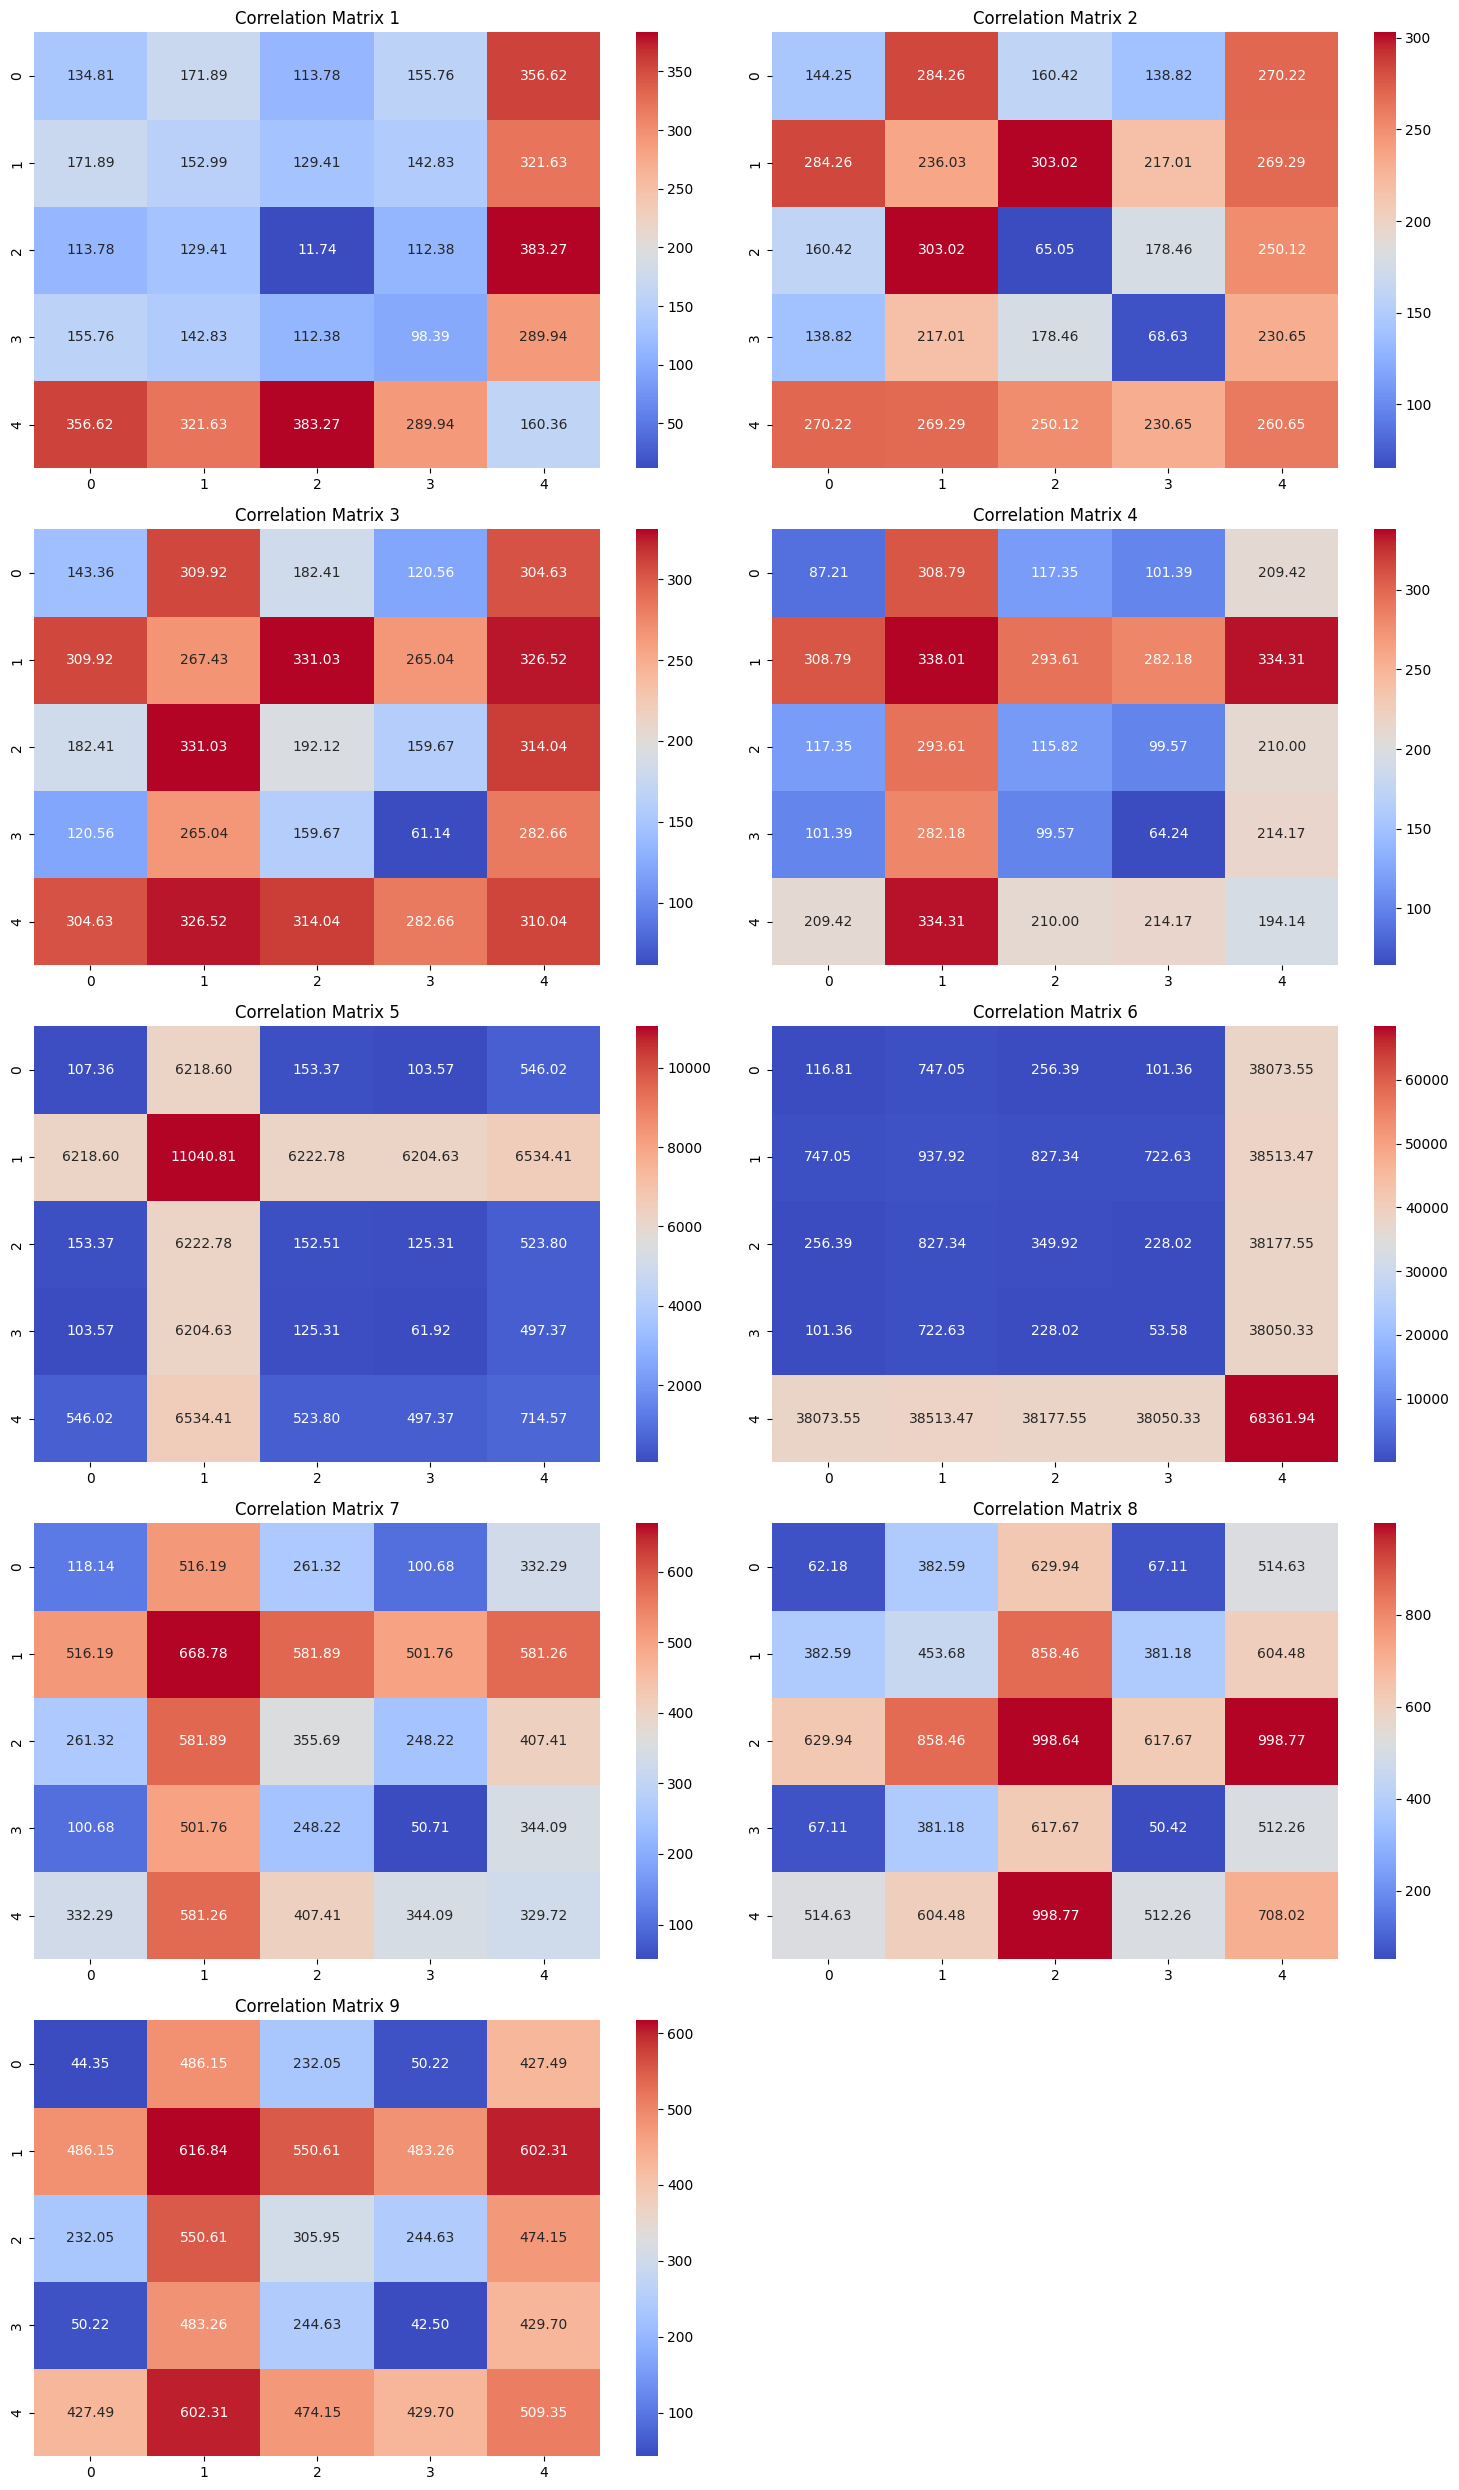

In [116]:
plot_heatmap(corr_vt)

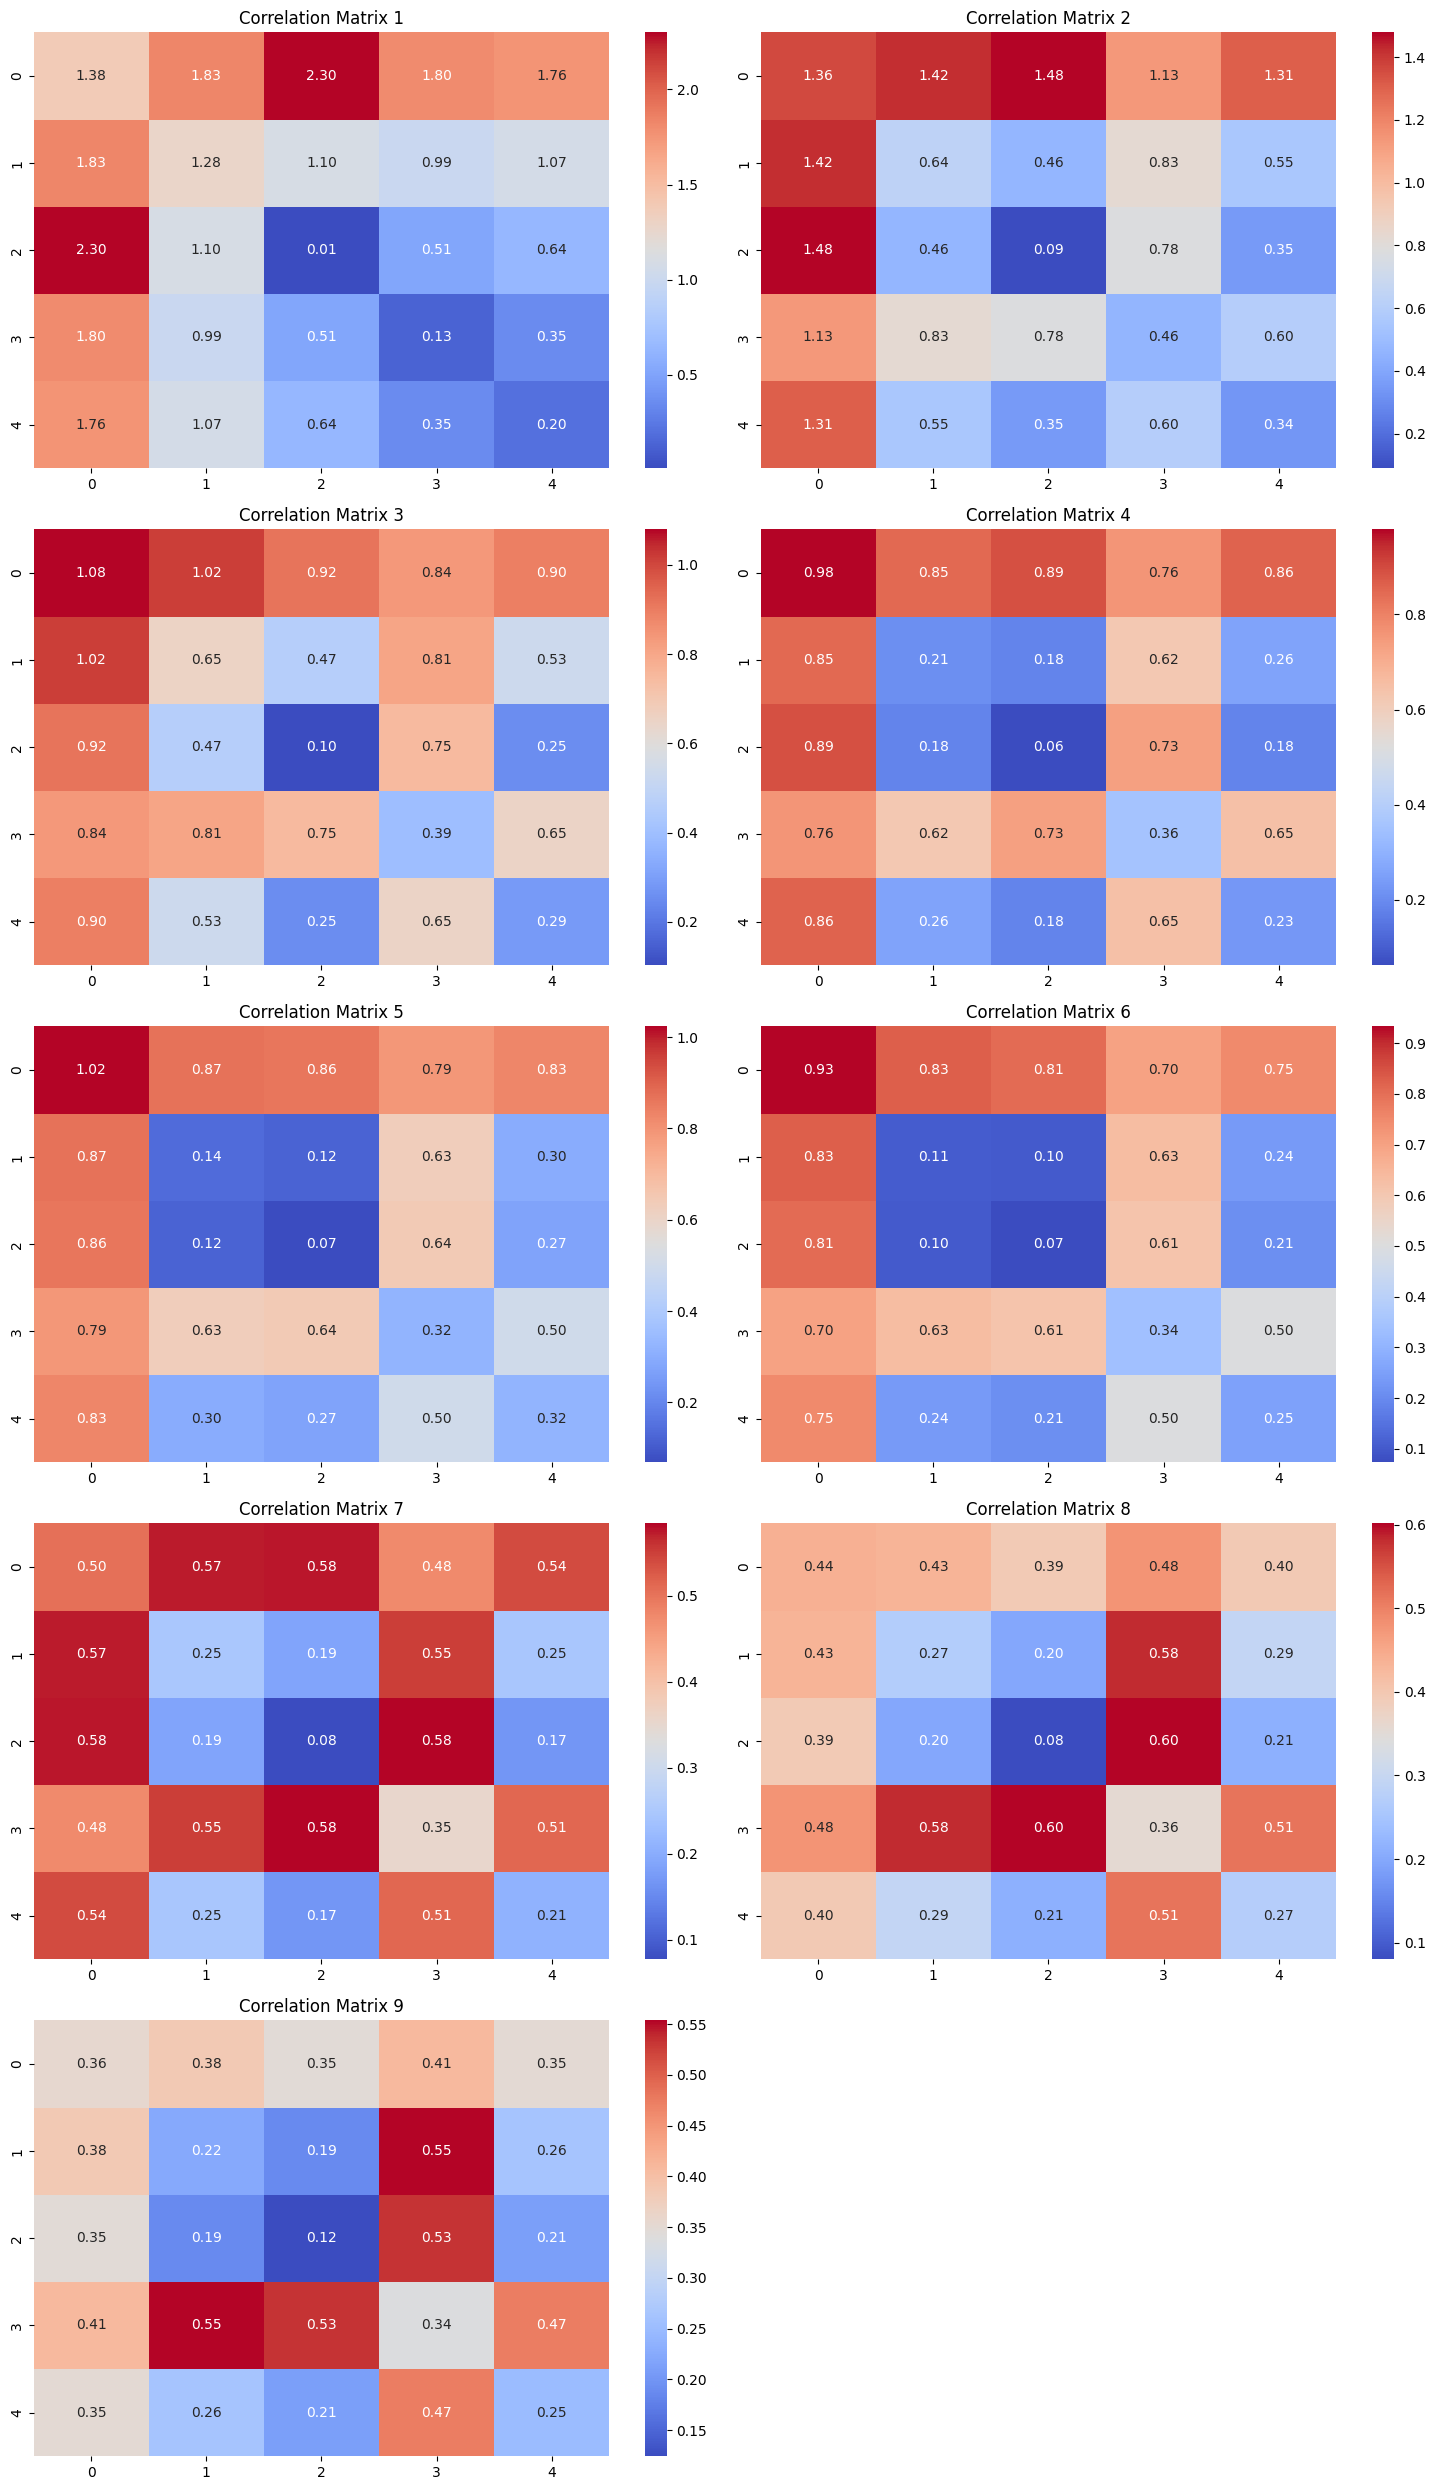

In [117]:
plot_heatmap(corr_glot)